# Import Package

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

# Read In an Test Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


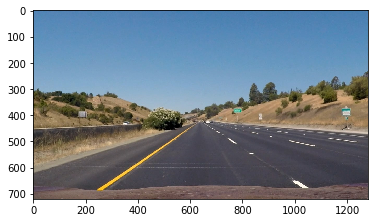

In [2]:
#reading in an image
test_image = mpimg.imread('test_images/straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(test_image), 'with dimensions:', test_image.shape)
plt.imshow(test_image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

# Camera Calibration

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# cheseboard images provided have 9X6 pattern 
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

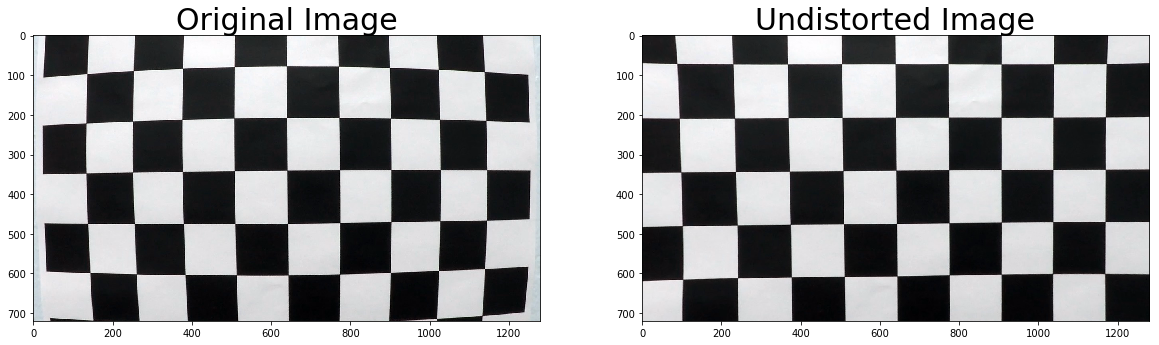

In [4]:
# Test undistortion on an image
img = cv2.imread(images[0])
img_size = (img.shape[1], img.shape[1])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Helper Functions

### Camera calibration function

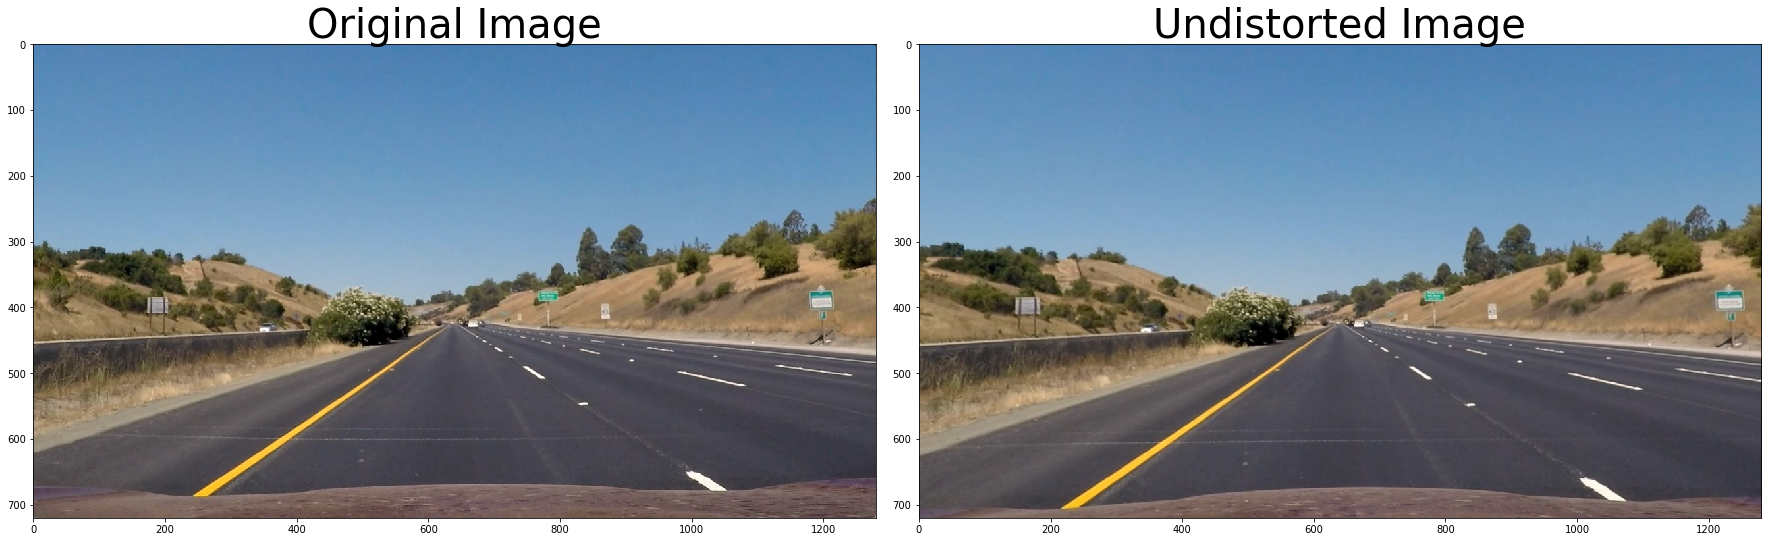

In [5]:
def camera_calibration(img, mtx=mtx, dist=dist):
    """Applies camera calibration using calibration 
    matrix and distortion coefficients calculated from 
    chessboard images"""
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

undistorted = camera_calibration(test_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Color and gradient thresholding function

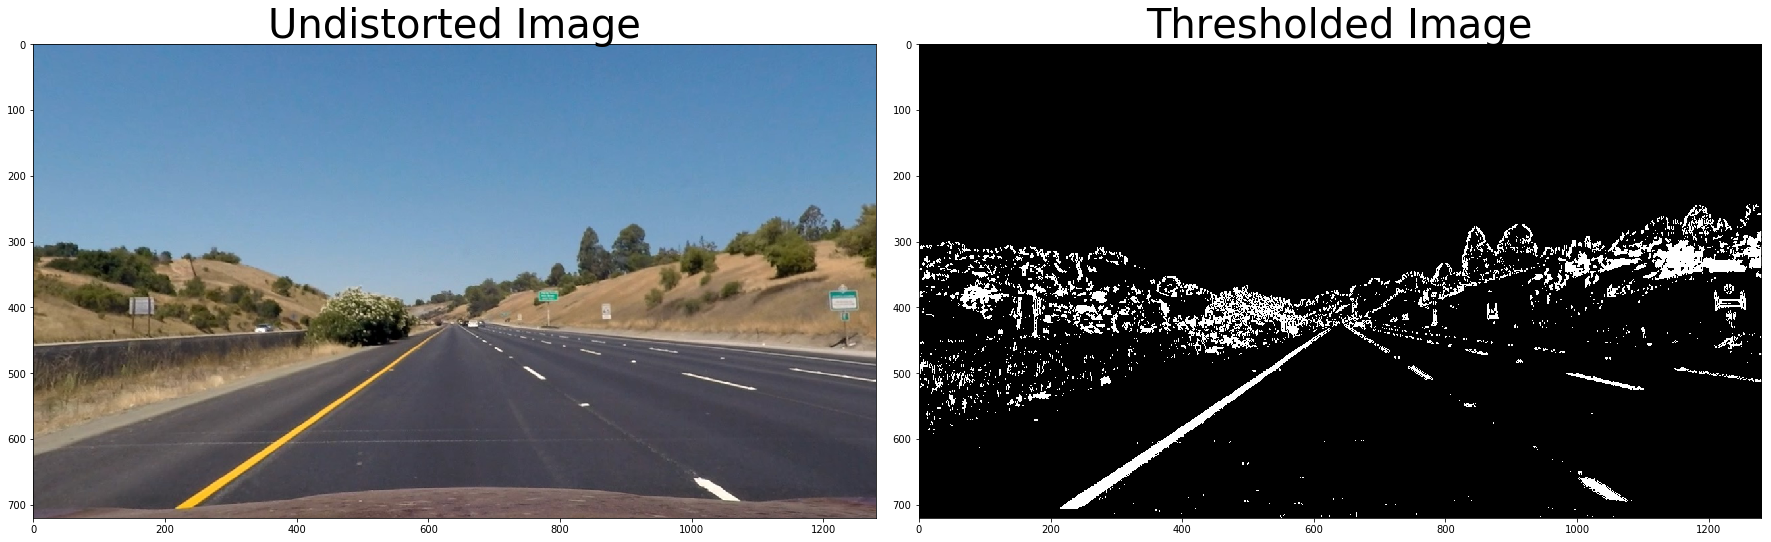

In [6]:
def color_gradient_threshold(img, sx_thresh=(20, 100)):
    """Applies color and gradient thresholding"""
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Define white range
    lower_white = np.uint8([0, 200, 0])
    upper_white = np.uint8([255, 255, 255])    
    # Define white mask
    w_mask = cv2.inRange(hls, lower_white, upper_white)
    
    # Define yellow range
    lower_yellow = np.uint8([10, 0, 100])
    upper_yellow = np.uint8([40, 255, 255])    
    # Define yellow mask
    y_mask = cv2.inRange(hls, lower_yellow, upper_yellow)
    
    # Combine white and yellow masks
    c_binary = cv2.bitwise_or(w_mask, y_mask)
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(c_binary != 0) | (sxbinary == 1)] = 1
    
    return combined_binary

thresholded = color_gradient_threshold(undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Undistorted Image', fontsize=40)

ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Perspective transform function

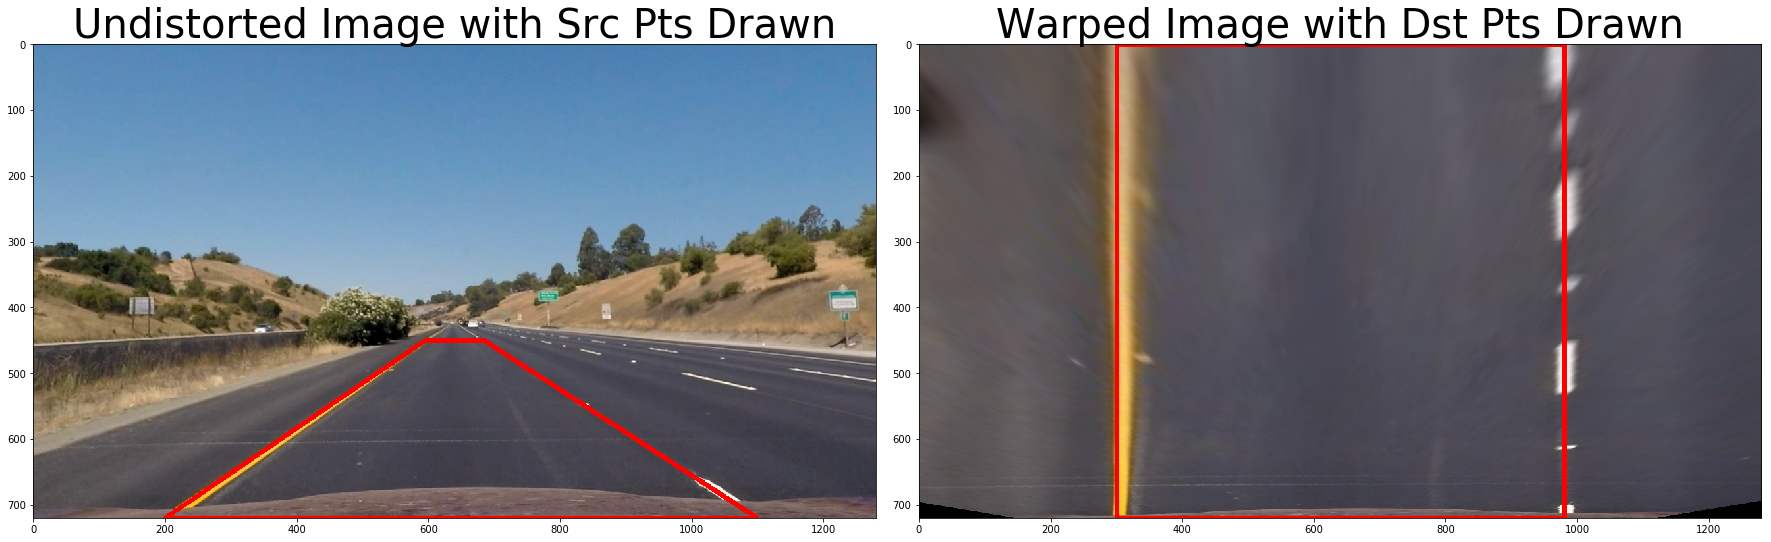

In [7]:
# Finding 4 sorce points and desination points for perspective transform
src_pts = np.float32([[595, 450], [200, 720], [1100, 720], [685, 450]])
dst_pts = np.float32([[300, 0], [300, 720], [980, 720], [980, 0]])

def perspective_transform(img, src_pts=src_pts, dst_pts=dst_pts):
    """Applies perspective transform"""
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    Minv = cv2.getPerspectiveTransform(dst_pts, src_pts)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv
    
# Test on straight lines
undistorted_with_src_pts = np.copy(undistorted)
cv2.polylines(undistorted_with_src_pts, [src_pts.astype(int)], True, (255, 0, 0), 5)

warped, M, Minv = perspective_transform(undistorted)
warped_with_dst_pts = np.copy(warped)
cv2.polylines(warped_with_dst_pts, [dst_pts.astype(int)], True, (255, 0, 0), 5)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted_with_src_pts)
ax1.set_title('Undistorted Image with Src Pts Drawn', fontsize=40)

ax2.imshow(warped_with_dst_pts)
ax2.set_title('Warped Image with Dst Pts Drawn', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

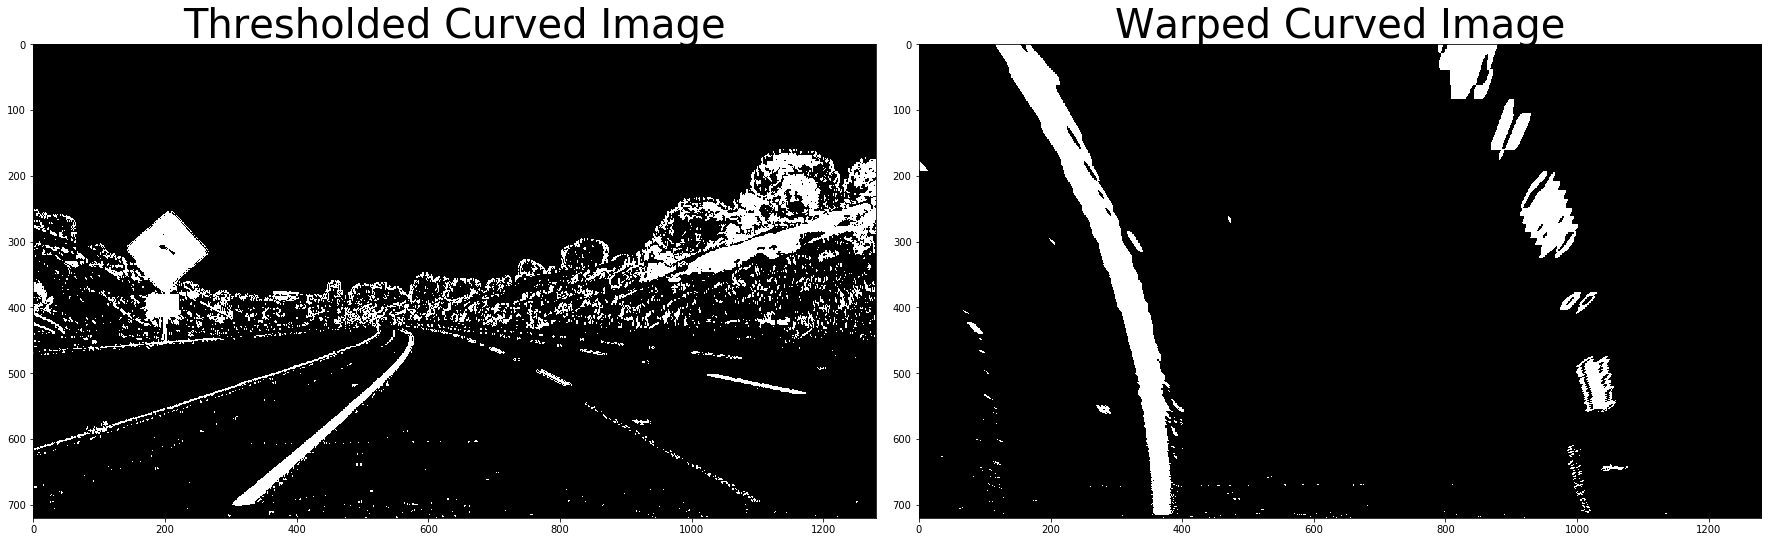

In [8]:
# Test on curved lines
curved_image = mpimg.imread('test_images/test2.jpg')
curved_undist = camera_calibration(curved_image)
curved_thres = color_gradient_threshold(curved_undist)

curved_warped, M, Minv = perspective_transform(curved_thres)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(curved_thres, cmap='gray')
ax1.set_title('Thresholded Curved Image', fontsize=40)

ax2.imshow(curved_warped, cmap='gray')
ax2.set_title('Warped Curved Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Sliding window search function for first (or reset) frame

In [9]:
def sliding_window(binary_warped, nwindows=9, margin=100, minpix=50, vis=False):
    """
    Sliding windows and fit a polynomial
    nwindows = no. of sliding windows
    margin = width of the windows +/- margin
    minpix = minimum number of pixels found to recenter window
    vis = output visualization or not
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)   
    
    if vis:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base 
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        if vis:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:           
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds) 
       
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if vis:
        # Draw on output image        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        return leftx, rightx, lefty, righty, left_fit, right_fit, out_img
    
    return leftx, rightx, lefty, righty, left_fit, right_fit

(720, 0)

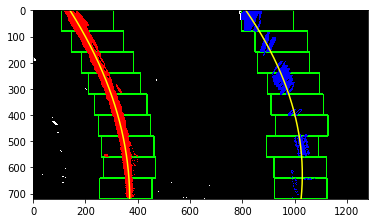

In [10]:
# Visualization
binary_warped = curved_warped
leftx, rightx, lefty, righty, left_fit, right_fit, out_img = sliding_window(binary_warped, vis=True)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Simpler search function for subsequent frames

In [11]:
def next_frame(binary_warped, left_fit, right_fit, margin=100, vis=False):
    """
    Skips sliding windows search and use fit from previous frame
    margin = width of the windows +/- margin
    vis = output visualization or not
    """
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if vis:  
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)      
        
        return leftx, rightx, lefty, righty, left_fit, right_fit, out_img
    
    return leftx, rightx, lefty, righty, left_fit, right_fit

(720, 0)

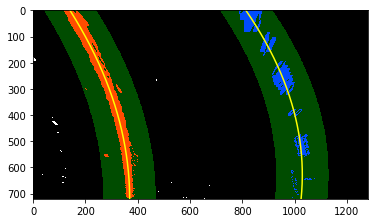

In [12]:
# Visualization for next frame
binary_warped = curved_warped
leftx, rightx, lefty, righty, left_fit, right_fit, out_img = next_frame(binary_warped, left_fit, right_fit, vis=True)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Curvature finding function

In [13]:
def find_curvature(left_fit, right_fit, ploty=ploty, my=30/720, mx=3.7/700):
    """
    Finds curvature in meters
    """
    # Convert from pixel to meters
    # x= mx/(my**2)*a*(y**2)+(mx/my)*b*y+c    
    y_eval = np.max(ploty) * my
    
    # Calculate new coefficients in meters
    left_a = mx/(my**2) * left_fit[0]
    left_b = (mx/my) * left_fit[1]
    right_a = mx/(my**2) * right_fit[0]
    right_b = (mx/my) * right_fit[1]
    
    # Calculate curvatures of left and right lanes
    left_curverad = ((1 + (2*left_a*y_eval + left_b)**2)**1.5) / np.absolute(2*left_a)
    right_curverad = ((1 + (2*right_a*y_eval + right_b)**2)**1.5) / np.absolute(2*right_a)
    
    return left_curverad, right_curverad

left_curverad, right_curverad = find_curvature(left_fit, right_fit)
print(left_curverad, 'm', right_curverad, 'm')

380.04011436 m 292.1888028 m


### Drawing lane lines onto original image

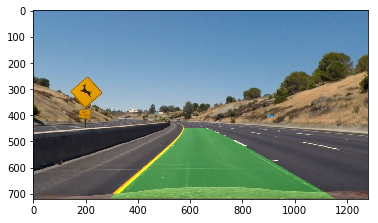

In [14]:
def draw_image(undist, warped, left_fitx=left_fitx, right_fitx=right_fitx, ploty=ploty, Minv=Minv, text=False):
    """
    Draws lines back to original images
    text: if showing statistics
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # Showing curvature and vehicle off-centering
    if text is True:        
        text_str1 = 'Radious of Curvature = '+str(np.average((left_lane.radius_of_curvature, right_lane.radius_of_curvature)).round(1))+' (m)'
        text_str2 = 'Vehicle Off From Center = '+str(((left_lane.line_base_pos-right_lane.line_base_pos)/2).round(2))+' (m)'
        cv2.putText(result, text_str1, (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(result, text_str2, (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
    return result

result = draw_image(curved_undist, binary_warped)
plt.imshow(result)

# Build a Lane Finding Pipeline

### Define Line() class to keep track on lane lines characteristics

In [15]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # counter to track how many frames lost
        self.lost_counter = 0
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def sanity_check(self, other):
        """
        Sanity check between last and new fits:
        1. Checking that they have similar curvature
        2. Checking that they are separated by approximately the right distance horizontally
        3. Checking that they are roughly parallel 
        """
        diff_curvature = self.radius_of_curvature - other.radius_of_curvature
        lane_dist = (np.mean(other.allx) - np.mean(self.allx)) * (3.7/700) # mx = 3.7/700 (meter/pixel)
        is_parallel = np.square(self.current_fit[:2] - other.current_fit[:2]).mean()
        
        if diff_curvature < 100 and (lane_dist > 3.2 or lane_dist < 4.2) and is_parallel < 0.01:
            return True
        
        return False
        
    def update(self, x_values, y_values, fit_coeff, curverad):
        """Updates instance attributes once passed
        sanity check with detected x-, y-values, 
        fit coefficients and curvature"""
        self.detected = True
        self.lost_counter = 0
        self.recent_xfitted.append(np.average(x_values))
        if len(self.recent_xfitted) > 5:
            self.recent_xfitted = self.recent_xfitted[1:]
        self.bestx = np.average(self.recent_xfitted)
        if self.best_fit is None:
            self.best_fit = fit_coeff
        else:
            self.best_fit = np.average((self.best_fit, fit_coeff), axis=0, weights=[len(self.recent_xfitted)-1, 1])        
        self.radius_of_curvature = curverad
        self.line_base_pos = np.absolute(640 - np.mean(x_values)) * (3.7/700) # mx = 3.7/700 (meter/pixel)        
        self.diffs = np.subtract(fit_coeff, self.current_fit)
        self.current_fit = fit_coeff
        self.allx = x_values
        self.ally = y_values
            
# Initiale Line() instances for left and right lane lines
left_lane = Line()
right_lane = Line()

### Image processing pipeline

In [16]:
def image_pipeline(img, mtx=mtx, dist=dist):
    # Apply camera calibration
    undistorted = camera_calibration(img, mtx=mtx, dist=dist)
    
    # Apply color and gradient thresholding
    thresholded = color_gradient_threshold(undistorted, sx_thresh=(20, 100))
    
    # Finding 4 sorce points and desination points for perspective transform
    src_pts = np.float32([[595, 450], [200, 720], [1100, 720], [685, 450]])
    dst_pts = np.float32([[300, 0], [300, 720], [980, 720], [980, 0]])
    # Apply perspective transform
    warped, M, Minv = perspective_transform(thresholded, src_pts=src_pts, dst_pts=dst_pts)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    
    if left_lane.detected and right_lane.detected and left_lane.lost_counter < 5 and right_lane.lost_counter < 5:  
        # Apply lane fit for subsequent frames
        leftx, rightx, lefty, righty, left_fit, right_fit = next_frame(warped, left_lane.current_fit, right_lane.current_fit, margin=100)
        # Find curvatures
        left_curverad, right_curverad = find_curvature(left_fit, right_fit, ploty=ploty, my=30/720, mx=3.7/700)
        # Sanity check
        new_left_lane = Line()
        new_left_lane.update(leftx, lefty, left_fit, left_curverad)
        new_right_lane = Line()
        new_right_lane.update(rightx, righty, right_fit, right_curverad)
        is_valid = new_left_lane.sanity_check(new_right_lane)        
        # Update Line() instance attributes if passed sanity check
        if is_valid:            
            left_lane.update(leftx, lefty, left_fit, left_curverad)
            right_lane.update(rightx, righty, right_fit, right_curverad)            
        else:
            left_lane.detected = False
            right_lane.detected = False
            left_lane.lost_counter += 1
            right_lane.lost_counter += 1
    else:
        # Sliding window search for first frame
        leftx, rightx, lefty, righty, left_fit, right_fit = sliding_window(warped, nwindows=9, margin=100, minpix=50)
        # Find curvatures
        left_curverad, right_curverad = find_curvature(left_fit, right_fit, ploty=ploty, my=30/720, mx=3.7/700)
        # Update Line() instance for first frame
        left_lane.update(leftx, lefty, left_fit, left_curverad)
        right_lane.update(rightx, righty, right_fit, right_curverad)     
    
    # Generate X for plotting
    left_fitx = left_lane.best_fit[0]*ploty**2 + left_lane.best_fit[1]*ploty + left_lane.best_fit[2]
    right_fitx = right_lane.best_fit[0]*ploty**2 + right_lane.best_fit[1]*ploty + right_lane.best_fit[2]  
        
    # Draw lines on original image
    result = draw_image(undistorted, warped, left_fitx=left_fitx, right_fitx=right_fitx, ploty=ploty, Minv=Minv, text=True)
    
    return result

### Try out our pipline for test images

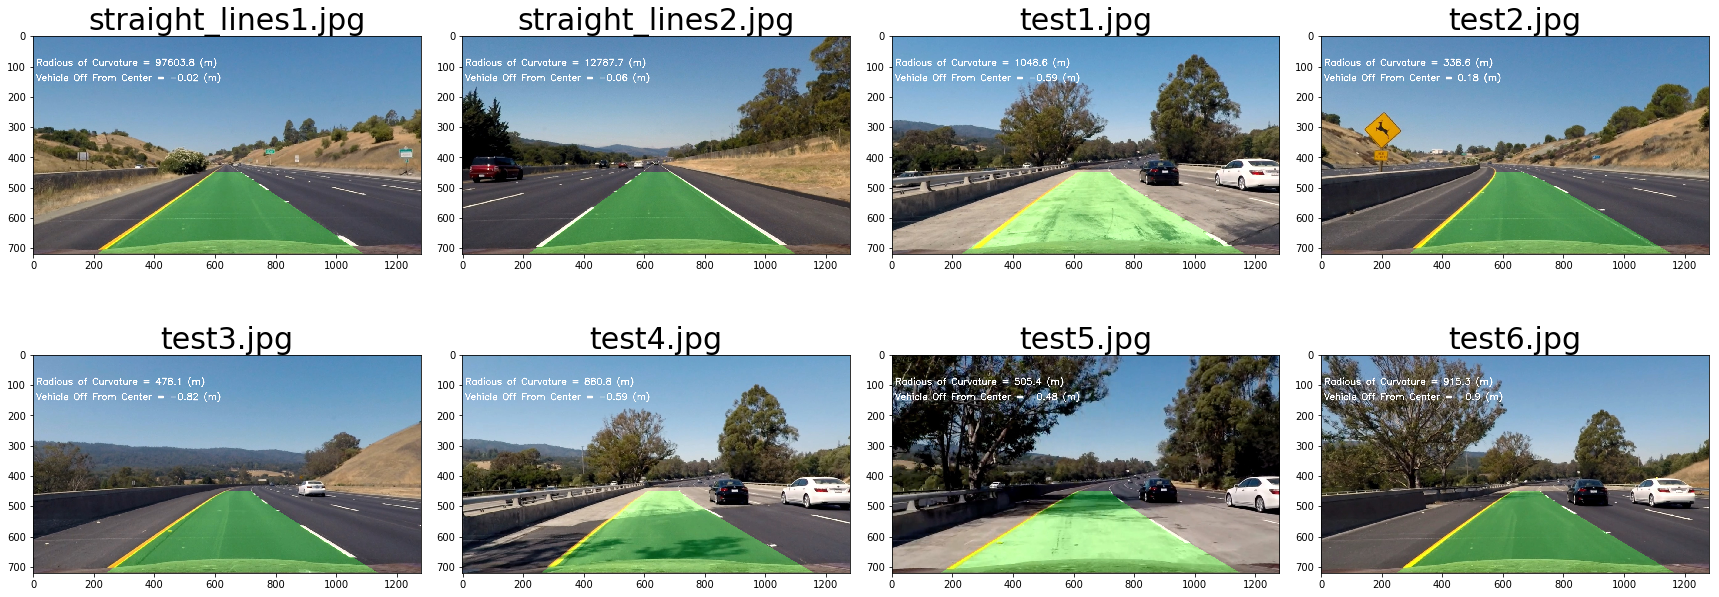

In [17]:
import os

# Process test images and plot the result
f, ax = plt.subplots(len(os.listdir('test_images/'))//4, 4, figsize=(24, 9))
f.tight_layout()
#ax.set_title('Original Image with Lane Line Drawn', fontsize=40)

for idx, test_image in enumerate(os.listdir('test_images/')):
    left_lane = Line()
    right_lane = Line()
    output_fname = 'output_images/'+test_image
    img = mpimg.imread('test_images/'+test_image)
    result = image_pipeline(img, mtx=mtx, dist=dist)
    mpimg.imsave(output_fname, result)
    ax[idx//4][idx%4].imshow(result)
    ax[idx//4][idx%4].set_title(test_image, fontsize=30)

# Test on Videos

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
project_output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(image_pipeline)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████▉| 1260/1261 [02:42<00:00,  8.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 2min 44s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))